<a href="https://colab.research.google.com/github/AlirezaAK2000/Adad_khon/blob/master/AI_First_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import numpy as np
import matplotlib.pyplot as plt

In [225]:
# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')
def right_shift(xs, num_shift):
  for i in range(num_shift):
    xs = np.c_[xs[:,-1],xs[:,:-1]]
  return xs
def read_data():
  train_images_file = open('drive/MyDrive/colab samples/train-images.idx3-ubyte', 'rb')
  train_images_file.seek(4)
  num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
  train_images_file.seek(16)

  train_labels_file = open('drive/MyDrive/colab samples/train-labels.idx1-ubyte', 'rb')
  train_labels_file.seek(8)

  train_set = []
  for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
      
    train_set.append((image, label))
  # Reading The Test Set
  test_images_file = open('drive/MyDrive/colab samples/t10k-images.idx3-ubyte', 'rb')
  test_images_file.seek(4)

  test_labels_file = open('drive/MyDrive/colab samples/t10k-labels.idx1-ubyte', 'rb')
  test_labels_file.seek(8)

  num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
  test_images_file.seek(16)

  shifted_test_set = []
  test_set = []
  for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    image_mat = np.zeros((28,28))
    for i in range(784):
        data = int.from_bytes(test_images_file.read(1), 'big') / 256
        image[i] = data
        image_mat[i // 28][i % 28] = data

    
    # corrupting data for adverserial attack
    image_mat = right_shift(image_mat , 4).flatten().reshape(-1,1)
    assert(image.shape == image_mat.shape)

    shifted_test_set.append(image_mat)

    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))

  train_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in train_set])))
  test_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in test_set])))

  train_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in train_set])))
  test_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in test_set])))

  shifted_test_set_x_v = np.transpose(np.squeeze(np.array(shifted_test_set)))

  assert(shifted_test_set_x_v.shape == test_set_x_v.shape)

  return train_set_x_v , test_set_x_v , train_set_y_v , test_set_y_v , shifted_test_set_x_v

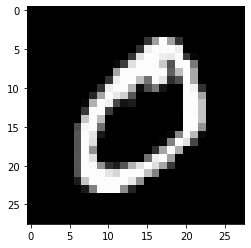


shifted pic :



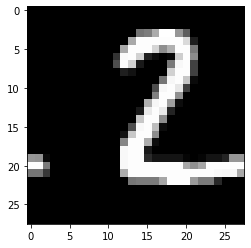

In [226]:
train_set_x_v , test_set_x_v , train_set_y_v , test_set_y_v , shifted_test_set_x_v= read_data()
show_image(np.transpose(train_set_x_v[:,1]))
plt.show()
# corrupted
print('\nshifted pic :\n')
show_image(np.transpose(shifted_test_set_x_v[:,1]))
plt.show()

In [227]:
def sigmoid(A):
  return 1/(1+np.exp(-1 * A))
def sigmoid_deriv(A):
  sig = sigmoid(A)
  return sig * (1 - sig)
def softmax(A):
  e = np.exp(A)
  return e / np.sum(e)
def relu(A):
  return np.maximum(A , 0)
def relu_deriv(A):
  return (A > 0).astype(int)
def tanh(A):
  return np.tanh(A)
def tanh_deriv(A):
  return 1 - tanh(A) ** 2
def leaky_relu(A,alpha=0.01):
  return np.where(A > 0, A, A * alpha)     
def leaky_relu_deriv(A, alpha=0.01):
  dx = np.ones_like(A)
  dx[A < 0] = alpha
  return dx                     

# Model

define your model here :

for the first element just shape of the input

```
(dataset_size , None)
```

for hidden layers define neurons , activation function and derivative

```
(neurons , activation , activation_deriv)
```


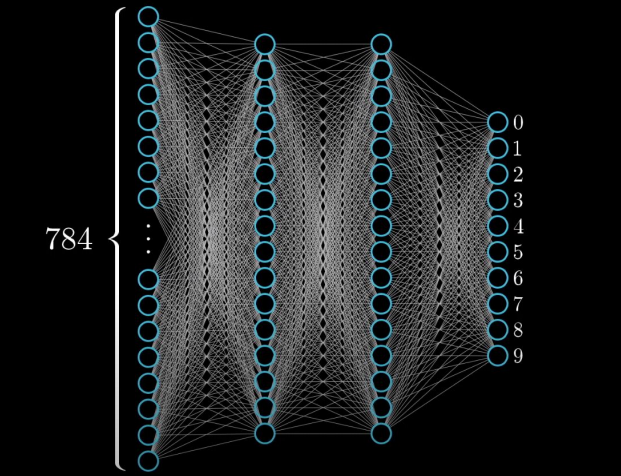


In [228]:
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
model

[(784, None),
 (16, <function __main__.relu>, <function __main__.relu_deriv>),
 (16, <function __main__.relu>, <function __main__.relu_deriv>),
 (10, <function __main__.sigmoid>, <function __main__.sigmoid_deriv>)]

In [229]:
np.random.seed(2)
def get_dimensions(model):
  dimensions = [(model[i+1][0], model[i][0]) for i in range(len(model)-1)]
  return dimensions
dimensions = get_dimensions(model)

# Weight Initialization 

using proper technique to initialize weights , helps model for faster and better learning.
here we are using **HE** initializing which is good for models with relu activation functions.
refrence : [He et al., 2015](https://arxiv.org/abs/1512.03385)

In [230]:
def initializer(shape ):
  w = np.random.randn(shape[0],shape[1]) * np.sqrt(2./shape[1])
  # b = np.random.randn(shape[0] , 1) * np.sqrt(2./shape[1])
  b = np.zeros((shape[0] , 1))

  return (w , b)
def V_initializer(shape ):
  v_w = np.zeros(shape)
  v_b = np.zeros((shape[0] , 1))

  return (v_w , v_b)

In [231]:
def initialize(model,use_momentum = False):
  W = []
  B = []
  for shape in dimensions:
    w , b  = initializer(shape)
    assert(w.shape == shape)
    assert(b.shape == (shape[0] , 1))
    W.append(w)
    B.append(b)
  if use_momentum:
    V = {'dW':[],'dB':[]}
    for shape in dimensions:
      v_w , v_b  = V_initializer(shape)
      V['dW'].append(v_w)
      V['dB'].append(v_b)
    return W , B , V

  return W , B , None
W , B , _ = initialize(model)

In [232]:
def mse_cost(y , y_prim):
  return np.sum((y_prim-y)**2)/y.shape[1]

In [233]:
def forward_propagation(X , W , B,model):
  layers_num = len(W)
  A = [X]
  Z = []
  for i in range(layers_num):
    # assert(W[i].shape[1] == X.shape[0])
    z = W[i] @ A[i] + B[i]
    a = model[i + 1][1](z)
    A.append(a)
    Z.append(z)
    # print(z.shape)
  return {
      'A':A,
      'Z':Z
  }

In [234]:
# print(train_set_x_v.shape)
cache = forward_propagation(train_set_x_v , W , B,model)
assert(train_set_y_v.shape == cache['A'][-1].shape)
for i in cache['A']:
  print(i.shape)

(784, 60000)
(16, 60000)
(16, 60000)
(10, 60000)


In [235]:
mse_cost(train_set_y_v,cache['A'][-1])
cache['Z'][0].shape

(16, 60000)

In [236]:
def backward_propagation(W , B , cache, Y , model):
  A , Z = cache['A'] ,cache['Z']
  # print(Z)
  dW , dB= [] , []
  layers_num = len(W)
  tmp = (2 * (A[-1] - Y)) * model[-1][2](Z[-1])
  db = tmp  @ np.ones((A[-1].shape[1],1))
  dw = tmp  @ np.transpose(A[-2])
  dA = [np.transpose(W[-1]) @ tmp]
  assert(dw.shape == W[-1].shape)
  assert(db.shape == B[-1].shape)
  dW.append(dw)
  dB.append(db)
  for i in reversed(range(layers_num - 1)):
    tmp = dA[0] * model[i+1][2](Z[i])
    db = tmp @ np.ones((tmp.shape[1],1))
    dw = tmp @ np.transpose(A[i])
    da = np.transpose(W[i]) @ tmp
    dA.insert(0,da)
    dW.insert(0,dw)
    dB.insert(0,db)
    assert(dw.shape == W[i].shape)
    assert(db.shape == B[i].shape)

  return {
      'dW':dW,
      'dB':dB
  }
    
def predict(W, B , X , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  return np.where(Y_prim.reshape(Y_prim.shape[1]) == 1)[0][0]



In [237]:
a = backward_propagation(W,B, cache,train_set_y_v , model)

In [238]:
from collections import defaultdict
def test(W, B , X ,Y , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  result = defaultdict(lambda : 0,dict(zip(*(np.unique((Y_prim == Y).all(0) , return_counts=True)))))
  return result[True] / (result[True] + result[False]) * 100


def main_model(model , X , Y ,X_test , Y_test , epoch=200 , batch_size=20 , a=1, use_momentum = False, beta=0.9):
  costs , test_accuracies , train_accuracies = [] , [] , []
  num_iteration = X.shape[1]//batch_size
  W , B , V = initialize(model,use_momentum)
  for i in range(epoch):
    cost = None
    for j in range(num_iteration):
      batch_x = X[:,j*batch_size:(j+1)*batch_size]
      batch_y = Y[:,j*batch_size:(j+1)*batch_size]
      cache = forward_propagation(batch_x , W,B,model)
      cost = mse_cost(batch_y , cache['A'][-1])
      gradients = backward_propagation(W , B , cache , batch_y , model)
      if not use_momentum:
        for k in range(len(W)):
          W[k] = W[k] - a * gradients['dW'][k]
          B[k] = B[k] - a * gradients['dB'][k]
      else:
        for k in range(len(W)):
          V['dW'][k] = beta * V['dW'][k] + (1 - beta) * gradients['dW'][k]
          W[k] = W[k] - a * V['dW'][k]
          V['dB'][k] = beta * V['dB'][k] + (1 - beta) * gradients['dB'][k]
          B[k] = B[k] - a * V['dB'][k]
    # if i % 10 == 0:
    train_accuracy = test(W , B , X , Y , model)
    test_accuracy = test(W , B , X_test , Y_test , model)
    print(f'*** epoch : {i} ======> cost : {cost} , train accuracy : {train_accuracy} , test accuracy : {test_accuracy}')
    costs.append(cost)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

  train_accuracy = test(W , B , X , Y , model)
  test_accuracy = test(W , B , X_test , Y_test , model)
  print('__________________________________________________')
  print(f"train accuracy: {train_accuracy}")
  print(f"test accuracy: {test_accuracy}")  
  return costs , test_accuracies , train_accuracies , W , B



In [239]:
def plot_result(info): 
  plt.plot([i for i in range(1,len(info[0])+1)] , info[0] , label='cost')
  plt.legend(loc="upper right", frameon=False)
  plt.show()
  plt.plot([i for i in range(1,len(info[1])+1)] , info[1] , label='test accuracy')
  plt.plot([i for i in range(1,len(info[2])+1)] , info[2] , label='train accuracy')
  plt.legend(loc="upper left", frameon=False)
  plt.show()

def describe_model(model):
  print('\n'.join([str({'activation units':model[i][0],'activation function':model[i][1].__name__ ,'parameters': model[i][0]*model[i-1][0] }) if model[i][1] else f'input layer : {model[i][0]}' for i in range(len(model))]))


input layer : 784
{'activation units': 16, 'activation function': 'relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.3136236519787705 , train accuracy : 70.63666666666667 , test accuracy : 70.61
*** epoch : 1 ======> cost : 0.01207056961682781 , train accuracy : 88.41 , test accuracy : 88.49000000000001
*** epoch : 2 ======> cost : 0.01167906853914099 , train accuracy : 89.81166666666667 , test accuracy : 89.25999999999999
*** epoch : 3 ======> cost : 0.001235651116700165 , train accuracy : 91.46666666666667 , test accuracy : 91.10000000000001
*** epoch : 4 ======> cost : 0.002282073528517205 , train accuracy : 92.80000000000001 , test accuracy : 92.33
*** epoch : 5 ======> cost : 0.0023243451020755314 , train accuracy : 91.91166666666668 , test accuracy : 91.03999999999999
*** epoch : 6 ======> cost : 0.001033940553546172 , t

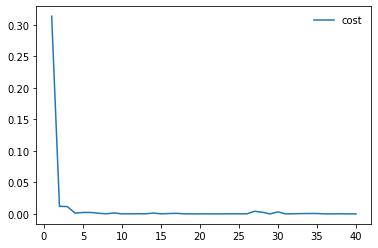

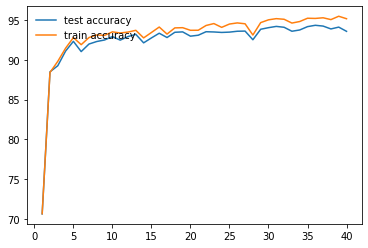

In [251]:
# using relu and momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.8)
plot_result(info)

No overfit !!!

input layer : 784
{'activation units': 16, 'activation function': 'relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.0025881642751869466 , train accuracy : 87.145 , test accuracy : 87.33999999999999
*** epoch : 1 ======> cost : 0.002481051040151156 , train accuracy : 88.52833333333334 , test accuracy : 88.18
*** epoch : 2 ======> cost : 0.0012901306168900486 , train accuracy : 90.65833333333333 , test accuracy : 90.42999999999999
*** epoch : 3 ======> cost : 0.0005141647832677988 , train accuracy : 91.36333333333333 , test accuracy : 90.94
*** epoch : 4 ======> cost : 0.0012898623532608404 , train accuracy : 92.015 , test accuracy : 91.24
*** epoch : 5 ======> cost : 0.008559561469191667 , train accuracy : 92.01 , test accuracy : 91.46
*** epoch : 6 ======> cost : 0.0009367281463851292 , train accuracy : 92.37833333333333 , te

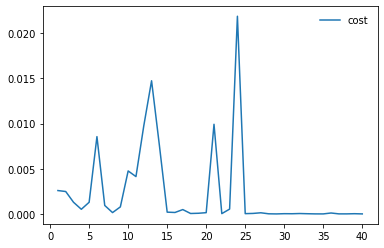

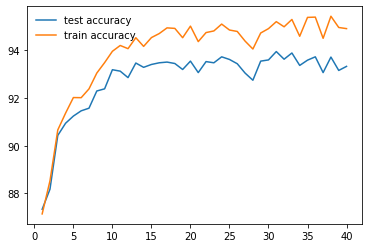

In [252]:
# using relu and without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=False)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.221620918682306 , train accuracy : 71.46000000000001 , test accuracy : 72.5
*** epoch : 1 ======> cost : 0.05375077024229229 , train accuracy : 85.87666666666667 , test accuracy : 86.0
*** epoch : 2 ======> cost : 0.038169234275651 , train accuracy : 88.63666666666667 , test accuracy : 88.57000000000001
*** epoch : 3 ======> cost : 0.03346878740562594 , train accuracy : 90.01333333333334 , test accuracy : 89.77000000000001
*** epoch : 4 ======> cost : 0.02826328488263563 , train accuracy : 90.97166666666666 , test accuracy : 90.68
*** epoch : 5 ======> cost : 0.022592509888294327 , train accuracy : 91.68333333333332 , test accuracy : 91.24
*** epoch : 6 ======> cost : 0.018165971099015188 , train accuracy 

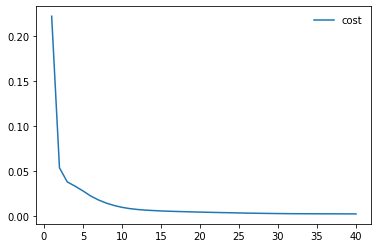

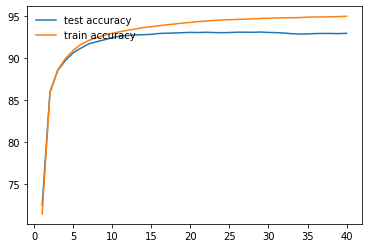

In [243]:
# using sigmoid with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.9)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.16740842364092812 , train accuracy : 77.77833333333334 , test accuracy : 78.97
*** epoch : 1 ======> cost : 0.04671785008411198 , train accuracy : 86.08666666666667 , test accuracy : 86.53999999999999
*** epoch : 2 ======> cost : 0.024325255587559373 , train accuracy : 88.41 , test accuracy : 88.32
*** epoch : 3 ======> cost : 0.017702005487250972 , train accuracy : 89.69666666666667 , test accuracy : 89.42
*** epoch : 4 ======> cost : 0.014814301676761552 , train accuracy : 90.49333333333334 , test accuracy : 90.07
*** epoch : 5 ======> cost : 0.013610260815776853 , train accuracy : 91.10666666666667 , test accuracy : 90.61
*** epoch : 6 ======> cost : 0.01347169193828468 , train accuracy : 91.62666666666

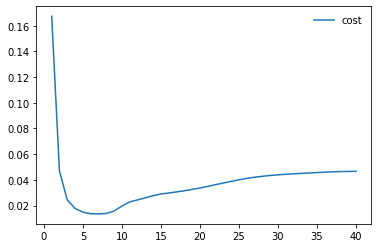

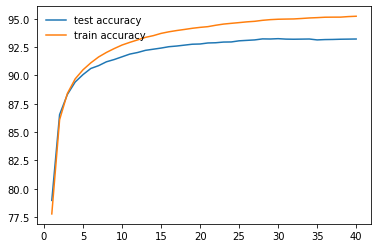

In [244]:
# using sigmoid without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 )
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'tanh', 'parameters': 12544}
{'activation units': 16, 'activation function': 'tanh', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.01581419170829741 , train accuracy : 86.52499999999999 , test accuracy : 86.94
*** epoch : 1 ======> cost : 0.00821161143692287 , train accuracy : 88.235 , test accuracy : 87.98
*** epoch : 2 ======> cost : 0.0041840343966075225 , train accuracy : 89.315 , test accuracy : 89.11
*** epoch : 3 ======> cost : 0.0029694784866169774 , train accuracy : 89.155 , test accuracy : 88.97
*** epoch : 4 ======> cost : 0.0018772349743405854 , train accuracy : 89.52166666666666 , test accuracy : 89.42
*** epoch : 5 ======> cost : 0.0018858467745693059 , train accuracy : 89.94666666666666 , test accuracy : 89.60000000000001
*** epoch : 6 ======> cost : 0.01245046712343455 , train accuracy : 90.64833333333333 , test accuracy : 9

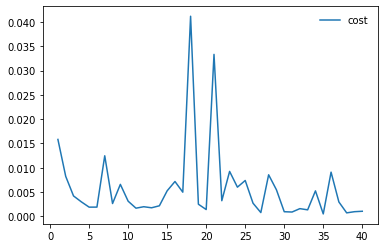

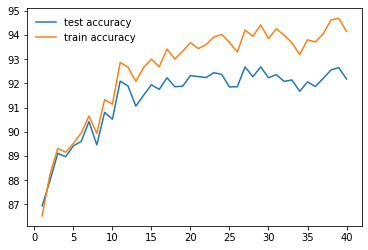

In [245]:
# using tanh with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , tanh ,tanh_deriv ),
    (16 , tanh ,tanh_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40, use_momentum=True , beta=0.9)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'tanh', 'parameters': 12544}
{'activation units': 16, 'activation function': 'tanh', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.11894364854675668 , train accuracy : 86.83833333333332 , test accuracy : 87.37
*** epoch : 1 ======> cost : 0.051589899736799075 , train accuracy : 89.77333333333334 , test accuracy : 89.38000000000001
*** epoch : 2 ======> cost : 0.03058567555708841 , train accuracy : 91.40833333333333 , test accuracy : 90.8
*** epoch : 3 ======> cost : 0.004086715130169967 , train accuracy : 91.38166666666667 , test accuracy : 90.7
*** epoch : 4 ======> cost : 0.02259428798260794 , train accuracy : 91.94833333333334 , test accuracy : 91.34
*** epoch : 5 ======> cost : 0.0025962577709414945 , train accuracy : 92.25 , test accuracy : 91.03999999999999
*** epoch : 6 ======> cost : 0.0031745086690896456 , train accuracy : 92.31166

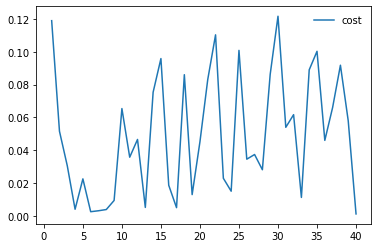

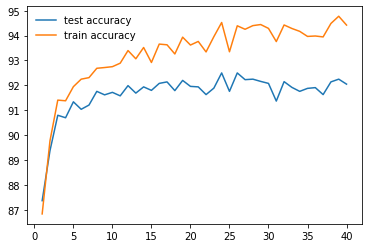

In [246]:
# using tanh without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , tanh ,tanh_deriv ),
    (16 , tanh ,tanh_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40, use_momentum=False )
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.17641157661472046 , train accuracy : 79.565 , test accuracy : 80.04
*** epoch : 1 ======> cost : 0.1592827559510926 , train accuracy : 81.25666666666666 , test accuracy : 80.75
*** epoch : 2 ======> cost : 0.16252336687589358 , train accuracy : 82.81166666666667 , test accuracy : 82.43
*** epoch : 3 ======> cost : 0.15942110671146714 , train accuracy : 83.09 , test accuracy : 82.86
*** epoch : 4 ======> cost : 0.1516925424465589 , train accuracy : 83.25166666666667 , test accuracy : 83.04
*** epoch : 5 ======> cost : 0.1559674880170005 , train accuracy : 83.86833333333334 , test accuracy : 83.34
*** epoch : 6 ======> cost : 0.1528371211487945 , train accuracy : 83.93 , test accuracy : 83.6
*** epoch 

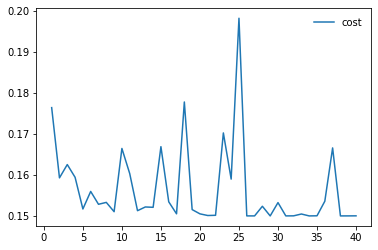

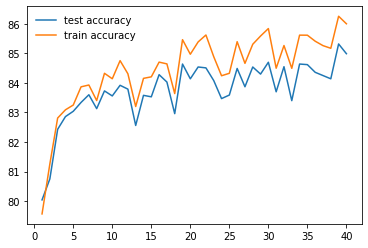

In [247]:
# using leaky relu with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.9)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.008169282822738098 , train accuracy : 87.63833333333334 , test accuracy : 87.89
*** epoch : 1 ======> cost : 0.0025679156390084924 , train accuracy : 90.07333333333334 , test accuracy : 90.2
*** epoch : 2 ======> cost : 0.012825994978946677 , train accuracy : 90.745 , test accuracy : 90.53
*** epoch : 3 ======> cost : 0.004279181449994358 , train accuracy : 91.32000000000001 , test accuracy : 90.84
*** epoch : 4 ======> cost : 0.0160165873093017 , train accuracy : 92.32166666666667 , test accuracy : 91.85
*** epoch : 5 ======> cost : 0.005839765992530289 , train accuracy : 91.91666666666667 , test accuracy : 91.38
*** epoch : 6 ======> cost : 0.0018026506263712002 , train accuracy : 92.58166666666666

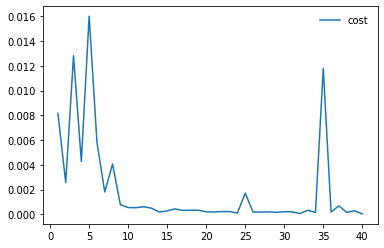

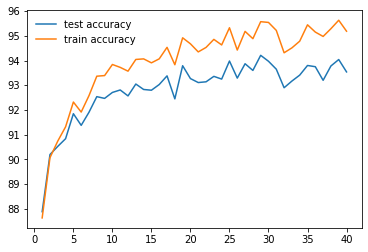

In [248]:
# using leaky relu without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=False)
plot_result(info)

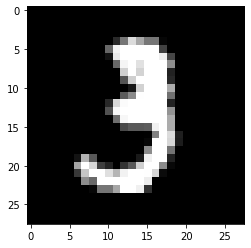

predicted value: 3


In [249]:
show_image(np.transpose(train_set_x_v[:,10]))
pic = train_set_x_v[:,10].reshape((1,-1,1))
W , B = info[3], info[4]
plt.show()
print(f"predicted value: {predict(W,B,pic, model )}")



input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.2364820078678279 , train accuracy : 71.39666666666666 , test accuracy : 10.780000000000001
*** epoch : 1 ======> cost : 0.05768627018583085 , train accuracy : 86.24333333333334 , test accuracy : 14.57
*** epoch : 2 ======> cost : 0.029196329513747364 , train accuracy : 88.34166666666667 , test accuracy : 15.36
*** epoch : 3 ======> cost : 0.022717759053471488 , train accuracy : 89.50333333333333 , test accuracy : 15.68
*** epoch : 4 ======> cost : 0.018146238855279363 , train accuracy : 90.325 , test accuracy : 16.63
*** epoch : 5 ======> cost : 0.01399471427462309 , train accuracy : 90.91 , test accuracy : 16.93
*** epoch : 6 ======> cost : 0.011392750933867584 , train accuracy : 91.365 , test accuracy : 

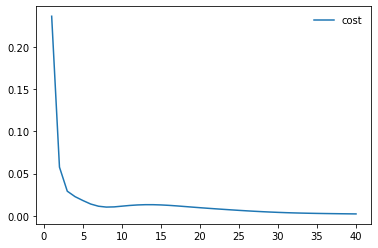

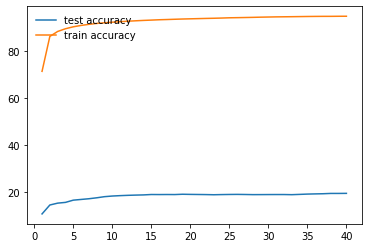

In [250]:
# testing corrupted dataset
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,shifted_test_set_x_v , test_set_y_v,a=0.01, epoch=40)
plot_result(info)